In [355]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from collections import defaultdict
from sklearn.metrics.pairwise import euclidean_distances

# 1 Node Classification [25 points]

### 1.1 Relational Classification [10 points]

As we discussed in class, we can use relational classification to predict node labels. Consider the
graph G as shown in Figure 1. We would like to classify nodes into 2 classes ”+” and ”-”. Labels
for node 3, 5, 8 and 10 are given (red for ”+”, blue for ”-”). Recall that using a probabilistic
relational classifier to predict label Y i for node i is defined as:

$ P(Y_{i} = c) = \frac{1}{|N_{i}|} \sum_{(i,j) \in E} W(i,j) P(Y_{j} = c)$ 

where $|N_{i}|$ is the number of neighbors of node i. Assume all the edges have edge weight $W (i, j) = 1$ in this graph. For labeled nodes, initialize with the ground-truth Y labels, i.e., $P (Y_{3} = +) = P(Y_{5} = +) = 1.0, P(Y_{8} = +) = P(Y_{10} = +) = 0 $. For unlabeled nodes, use unbiased initialization $P(Y_{i}= +) = 0.5$. Update nodes by node ID in ascending order (i.e., update node 1 first, then node 2, etc.)

In [85]:
edges = [(1,2), (1,3), (2,3),
         (2,4), (3,6), (4,7),
         (4,8), (5,8), (5,9),
         (5,6), (6,9), (6, 10),
         (7,8), (8,9), (9,10)]
nodes = list(range(10))
pos_nodes = [3,5]
neg_nodes = [8, 10]

G = defaultdict(list)
for i, j in edges:
    G[i-1].append(j-1)
    G[j-1].append(i-1)
G = dict(G)

#### (i) After the second iteration, give $P(Y_{i} = +)$ for i = 2, 4, 6. [6 points]

In [83]:
def Q1_1(nb_it=20, ep=1e-6, idxs=[2,4,6]):
    P = [ 0.5 for i in nodes]
    for i in pos_nodes:
        P[i-1] = 1
    for i in neg_nodes:
        P[i-1] = 0
    print(P)
    it = 1
    has_change = True
    while (it <= nb_it) and has_change:
        print(f'It: {it}')
        has_change = False
        for node in nodes:
            if (node+1 in pos_nodes) or (node+1 in neg_nodes):
                continue

            nids = G[node]
            p = sum([P[j] for j in nids])
            p_new = p / len(nids)
            if abs(P[node] - p_new) > ep:
                has_change = True
            P[node] = p_new
        if it == 2:
            print([(i, P[i-1]) for i in idxs])
        it += 1
    return P

In [84]:
P = Q1_1()

[0.5, 0.5, 1, 0.5, 1, 0.5, 0.5, 0, 0.5, 0]
It: 1
It: 2
[(2, 0.7638888888888888), (4, 0.32407407407407407), (6, 0.6015625)]
It: 3
It: 4
It: 5
It: 6
It: 7
It: 8
It: 9
It: 10
It: 11
It: 12
It: 13
It: 14


#### If we use 0.5 as the probability threshold, i.e., consider a node i belonging to class ”+” if $P(Y_{i} = +) > 0.5$, which node will belong to class ”+” in the end? Which will belong to class”-”? [4 points]

In [95]:
P
for n, p in zip(nodes, P):
    if p > 0.5:
        print(f'Node: {n+1} ;P={p:.2f}--> +')
    else:
        print(f'Node: {n+1} ;P={p:.2f}--> -')

Node: 1 ;P=0.86--> +
Node: 2 ;P=0.71--> +
Node: 3 ;P=1.00--> +
Node: 4 ;P=0.29--> -
Node: 5 ;P=1.00--> +
Node: 6 ;P=0.60--> +
Node: 7 ;P=0.14--> -
Node: 8 ;P=0.00--> -
Node: 9 ;P=0.40--> -
Node: 10 ;P=0.00--> -


### 1.2 Belief Propagation [15 points]
* reading: http://helper.ipam.ucla.edu/publications/gss2013/gss2013_11344.pdf

In this problem, we will be using Belief Propagation(BP) on Conditional Random Field to solve inference problems. Conditional Random Fields (CRF) are an important special case of Markov Random Fields to model conditional probability distribution. They define a probability distribution p over variables

* Message $ m_{ij}(x_{j})$: can be intuitively understood as a message from hidden node $x_{i}$ to hidden node $x_{j}$ about what state node i thinks node j should be in.

$ m_{ij}(x_{j}) = \sum_{x_{i}} φ_{i}(x_{i}) ψ_{ij}(x_{i}, x_{j}) \prod_{k\in N_{i} / j} m_{ki}(x_{i})$

* Belief $ b_{i}(x_{i})$ : $ b_{i}(x_{i}) = \frac{1}{Z} φ_{i}(x_{i}) \prod_{j \in N_{i}} m_{ji}(x_{i})$, where Z denotes the normalizing constant that ensures elements in $b_{i}(x_{i})$ sum to 1

##### (i) Consider the network with four hidden nodes shown in Figure 3. Compute the belief at node 1, b 1 (x 1 ), using the belief propagation rules, and write the result in terms of φ’s and ψ’s. [5 points]

* $ b_{1}(x_{1})   = \frac{1}{Z} φ_{1}(x_{1}) m_{21}(x_{1})$
* $\quad\quad\quad = \frac{1}{Z} φ_{1}(x_{1}) m_{21}(x_{1})$
* $ m_{21}(x_{1}) = \sum_{x_{2}} φ_{2}(x_{2}) ψ_{21}(x_{2}, x_{1})  m_{32}(x_{2})  m_{42}(x_{2})$
* $ \quad\quad\quad  = \sum_{x_{2}} φ_{2}(x_{2}) ψ_{21}(x_{2}, x_{1})  \sum_{x_{3}} φ_{3}(x_{3}) ψ_{32}(x_{3}, x_{2})  \sum_{x_{4}} φ_{4}(x_{4}) ψ_{42}(x_{4}, x_{2})$
* $ \quad\quad\quad  = \sum_{x_{2}} \sum_{x_{3}} \sum_{x_{4}} φ_{2}(x_{2}) φ_{3}(x_{3}) φ_{4}(x_{4}) ψ_{21}(x_{2}, x_{1}) ψ_{32}(x_{3}, x_{2}) ψ_{42}(x_{4}, x_{2})$

* $ b_{1}(x_{1}) = \frac{1}{Z} φ_{1}(x_{1}) \sum_{x_{2}} \sum_{x_{3}} \sum_{x_{4}} φ_{2}(x_{2}) φ_{3}(x_{3}) φ_{4}(x_{4}) ψ_{21}(x_{2}, x_{1}) ψ_{32}(x_{3}, x_{2}) ψ_{42}(x_{4}, x_{2})$

#### (ii) Prove that the belief at node 1 calculated above, $b_{1}(x_{1})$, is the same as the marginal probability of x 1 conditioned on the observations, $p(x_{1} |y_{1}, y_{2}, y_{3}, y_{4})$. [2 points],
ref: http://helper.ipam.ucla.edu/publications/gss2013/gss2013_11344.pdf

* $ b_{1}(x_{1}) = \frac{1}{Z} φ_{1}(x_{1}) \sum_{x_{2}} \sum_{x_{3}} \sum_{x_{4}} φ_{2}(x_{2}) φ_{3}(x_{3}) φ_{4}(x_{4}) ψ_{21}(x_{2}, x_{1}) ψ_{32}(x_{3}, x_{2}) ψ_{42}(x_{4}, x_{2})$

* $ b_{1}(x_{1}) = \frac{1}{Z} \sum_{x_{2}} \sum_{x_{3}} \sum_{x_{4}} φ_{1}(x_{1})  φ_{2}(x_{2}) φ_{3}(x_{3}) φ_{4}(x_{4}) ψ_{21}(x_{2}, x_{1}) ψ_{32}(x_{3}, x_{2}) ψ_{42}(x_{4}, x_{2})$

* $ b_{1}(x_{1}) = \frac{1}{Z} \sum_{x_{2}} \sum_{x_{3}} \sum_{x_{4}} p(x_{1}, x_{2}, x_{3}, x_{4} |y_{1}, y_{2}, y_{3}, y_{4})$

* $ b_{1}(x_{1}) = \frac{1}{Z} p(x_{1} |y_{1}, y_{2}, y_{3}, y_{4})$

#### (iii) Let’s work with a graph without cycles as shown in Figure 4. Assume x and y only have two states (0 and 1) and the graphical model has 5 hidden variables, and two variables observed with y 2 = 0, y 4 = 1. The compatibility matrices are given in the arrays below

In [217]:
# States --> {0, 1}
y2 = 0
y4 = 1

psi_1_2 = np.array([[1, 0.9],
                    [0.9, 1]])
psi_3_4 = psi_1_2
psi_2_3 = np.array([[0.1, 1],
                    [1, 0.1]])
psi_3_5 = psi_2_3

phi_2 = np.array([[1, 0.1],
                  [0.1, 1]])
phi_4 = phi_2

$ m_{53}(x_{3}) = \sum_{x_{5}} φ_{5}(x_{5}) ψ_{53}(x_{5}, x_{3}) $

$ m_{43}(x_{3}) = \sum_{x_{4}} φ_{4}(x_{4}) ψ_{43}(x_{4}, x_{3}) $

$ m_{32}(x_{2}) = \sum_{x_{3}} φ_{3}(x_{3}) ψ_{32}(x_{3}, x_{4})  m_{43}(x_{3})  m_{53}(x_{3})$

$ m_{21}(x_{1}) = \sum_{x_{2}} φ_{2}(x_{2}) ψ_{21}(x_{2}, x_{1})  m_{32}(x_{2})$

$ m_{12}(x_{2}) = \sum_{x_{1}} φ_{1}(x_{1}) ψ_{12}(x_{1}, x_{2})$

$ m_{23}(x_{3}) = \sum_{x_{2}} φ_{2}(x_{2}) ψ_{23}(x_{2}, x_{3})  m_{12}(x_{2})$

$ m_{34}(x_{4}) = \sum_{x_{3}} φ_{3}(x_{3}) ψ_{34}(x_{3}, x_{4})  m_{23}(x_{3})  m_{53}(x_{3})$

$ m_{35}(x_{5}) = \sum_{x_{3}} φ_{3}(x_{3}) ψ_{35}(x_{3}, x_{5})  m_{23}(x_{3})  m_{43}(x_{3})$

In [276]:
m53_x3 = np.sum(psi_3_5, axis=0)
m43_x3 = np.dot(psi_3_4, phi_4[:, y4])

m32_x2 = np.dot(psi_2_3, (m53_x3 * m43_x3).reshape(-1, 1))

m21_x1 = np.dot(psi_1_2, phi_2[:,y2].reshape(-1,1) * m32_x2)

m12_x2 = np.sum(psi_1_2, axis=0)

m23_x3 = np.dot(psi_2_3, phi_2[:,y2] * m12_x2)

m34_x4 = np.dot(psi_3_4, m23_x3 * m53_x3)

m35_x5 = np.dot(psi_3_5, m23_x3 * m43_x3)

$ b_{1}(x_{1}) = \frac{1}{Z} φ_{1}(x_{1}) m_{21}(x_{1})$

$ b_{2}(x_{2}) = \frac{1}{Z} φ_{2}(x_{2}) m_{12}(x_{2}) m_{32}(x_{2}) $

$ b_{3}(x_{3}) = \frac{1}{Z} φ_{3}(x_{3}) m_{23}(x_{3}) m_{43}(x_{3}) m_{53}(x_{3}) $

$ b_{4}(x_{4}) = \frac{1}{Z} φ_{4}(x_{4}) m_{34}(x_{4})$

$ b_{5}(x_{5}) = \frac{1}{Z} φ_{5}(x_{5}) m_{35}(x_{5})$

In [293]:
Z_1 = np.sum(m21_x1)
b1_x1 = (1/Z_1) * m21_x1

aux = phi_2[:,y2].reshape(-1, 1) * m12_x2.reshape(-1, 1) * m32_x2
Z_2 = np.sum(aux)
b2_x2 = (1/Z_2) * aux

aux = (m23_x3 * m43_x3 * m53_x3).reshape(-1, 1)
Z_3 = np.sum(aux)
b3_x3 = (1/Z_3) * aux

aux = (phi_4[:, y4] * m34_x4).reshape(-1, 1)
Z_4 = np.sum(aux)
b4_x4 = (1/Z_4) * aux

Z_5 = np.sum(m35_x5)
b5_x5 = (1/Z_5) * m35_x5.reshape(-1, 1)

In [306]:
for i, p in enumerate([b1_x1, b2_x2, b3_x3, b4_x4, b5_x5], 1):
    print(f'b{i}(x{i}) = ')
    print(p, "\n")

b1(x1) = 
[[0.52182902]
 [0.47817098]] 

b2(x2) = 
[[0.91475133]
 [0.08524867]] 

b3(x3) = 
[[0.15373972]
 [0.84626028]] 

b4(x4) = 
[[0.08524867]
 [0.91475133]] 

b5(x5) = 
[[0.78330387]
 [0.21669613]] 



#### Is the prediction what you expected? [8 points]
* x2, x4 are strong biases for being in state 0, 1 (y2, y4)
* x1 shows a slight preference for state 0 (influences of x2)
* x3 strong biases for being in state 1 (compatibility matrix)(x3 tended to be opposite to x2 and slighty similiar to x4)
* x5 biases for being in state 1 (compatibility matrix)(x5 tended to be opposite to x3)

# 2 Node Embeddings with TransE [25 points]

### 2.1 Warmup: Why the Comparative Loss? [3 points]

* $ L_{simple} = \sum_{(h,l,t) \in S} d(\boldsymbol h + \boldsymbol l, \boldsymbol t)$

{}

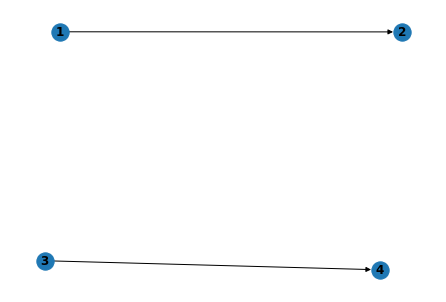

In [329]:
g = nx.DiGraph()
for node in [1,2,3,4]:
    g.add_node(node)
for edge in [(1,2), (3,4)]:
    g.add_edge(*edge)
nx.draw(g, with_labels=True, font_weight='bold')
labels = nx.get_edge_attributes(g, 'weight')
pos = nx.spring_layout(g)
nx.draw_networkx_edge_labels(g, pos, edge_labels=labels)

Let have only one relation, and the embeddings the followings:
* $ \boldsymbol l = [1, -1]$ 
* $ \boldsymbol e_{1} = \boldsymbol e_{3} = [0, 1]$
* $ \boldsymbol e_{2} = \boldsymbol e_{4} = [1, 0]$

In [348]:
l = np.array([[1, -1]])
e1 = np.array([[0, 1]])
e3 = e1
e2 = np.array([[1, 0]])
e4 = e2

* $ L_{simple} = d(\boldsymbol e_1 + \boldsymbol l, \boldsymbol e_2) + d(\boldsymbol e_1 + \boldsymbol l, \boldsymbol e_2) = 0$

In [354]:
l_simple = euclidean_distances(e1+l, e2)[0][0] + euclidean_distances(e3+l, e4)[0][0]
l_simple

0.0

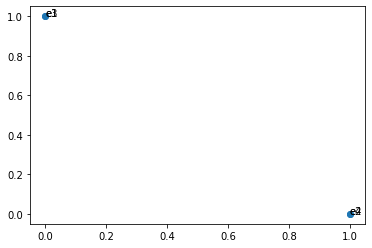

In [369]:
samples = np.concatenate([e1, e2, e3, e4])
x = samples[:, 0]
y = samples[:, 1]
n = ["e1", "e2", "e3", "e4"]

fig, ax = plt.subplots()
ax.scatter(x=x, y=y)
for i, txt in enumerate(n):
    ax.annotate(txt, (x[i], y[i]))

* So we had a loss value of 0 and useless embeddings because $ e_{1}$ is equal to $e_{3} $ and $e_{2} $ to $e_{4}$ but in the graph it make non sense to be close enough.

### 2.2 The Purpose of the Margin [5 points]

* Same example as above.

In [389]:
neg_sampling_1 = {
    euclidean_distances(e1+l, e3)[0][0],
    euclidean_distances(e1+l, e4)[0][0],
    euclidean_distances(e3+l, e2)[0][0],
    euclidean_distances(e4+l, e2)[0][0]
}

neg_sampling_2 = {
    euclidean_distances(e3+l, e1)[0][0],
    euclidean_distances(e3+l, e2)[0][0],
    euclidean_distances(e1+l, e4)[0][0],
    euclidean_distances(e2+l, e4)[0][0]    
}

l_margin1 = np.sum([
    max(euclidean_distances(e1+l, e2)[0][0] - neg_sampling, 0)
    for neg_sampling in neg_sampling_1
])
l_margin2 = np.sum([
    max(euclidean_distances(e3+l, e4)[0][0] - neg_sampling, 0)
    for neg_sampling in neg_sampling_2
])
l_margin = l_margin1 + l_margin2
l_margin

0.0